In [1]:
# Exports QuantumCollocation, NamedTrajectories, and TrajectoryIndexingUtils
using QuantumCollocation
using NamedTrajectories
using TrajectoryIndexingUtils
using LinearAlgebra

# Plots
using CairoMakie

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units

const n_qubits = 1
const n_levels = 2

t_f = 50 * ns
n_steps = 101
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
Δt = times[2] - times[1]

0.5

In [3]:
# Operators
Paulis = Dict(
    "I" => Matrix{ComplexF64}(I, 2, 2),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)
# X0=kron(Paulis["X"],Paulis["I"])
# Y0=kron(Paulis["Y"],Paulis["I"])
# X1=kron(Paulis["I"],Paulis["X"])
# Y1=kron(Paulis["I"],Paulis["Y"])

excitation(theta) = exp(-im/2 * theta * (Paulis["Z"]))

excitation (generic function with 1 method)

In [4]:
a = [0 1; 0 0]
ad = transpose(a);

In [5]:
H_drift = [ ]
H_drives = [
#     ad0 * a0,
#     ad1 * a1,
     a + ad,
     im * (a - ad),
#      a1 + ad1,
#      im * (a1 - ad1),
#     ad0 * a1 + a0 * ad1,
]
system = QuantumSystem(H_drives);

In [6]:
PICO_max_iter = 100

# Shape the cost function with weights on states and controls
Q = 100.
R =1e-4
# Add control bounds
a_bound = 2 * π * 100 * MHz
dda_bound = .02
initial_infidelities = []
initial_trajectories = []

ops = Options()
#ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0

for theta in range(0,pi/5,10)    
    temp_trajectories =[]
    temp_infidelities=[]
    print("-----------------------")
    print("Angle "*string(theta))
    println("-----------------------")
    target = excitation(theta)
   # guess = nothing
#     if(theta > 0 )
#         guess = initial_trajectories[length(initial_trajectories)][:a]
#     end
    U_guess = nothing
    if(length(initial_trajectories) > 0)
        U_guess = initial_trajectories[length(initial_trajectories)][:Ũ⃗]
    end
    for j in 1:5
        println("Iteration "*string(j))
        println("-----------------------")
        p = UnitarySmoothPulseProblem(
            system,
            target,
            n_steps,
            Δt;
            a_bound=a_bound,
            U_track =U_guess,
            dda_bound=dda_bound,
            Q=Q,
            R=R,
            verbose=true,
            hessian_approximation=true,
            pade_order=10,
            free_time=false,
            timesteps_all_equal=true,
            subspace=[1,2],
            max_iter=PICO_max_iter,
            ipopt_options=ops,
            #geodesic=true
        )
        solve!(p)
        result = copy(p.trajectory)
        push!(temp_trajectories,result)
        states = map(iso_vec_to_operator, eachslice(result[:Ũ⃗], dims=2))
        println("Infidelity " *string(unitary_infidelity(result[:Ũ⃗][:, end], operator_to_iso_vec(target))))
        rollout_states = unitary_rollout(result, system; integrator=exp)
        ΔUs = map(norm, eachslice(rollout_states .- result[:Ũ⃗], dims=2))
        println("Rollout Error "*string(maximum(ΔUs)))
        println("Infidelity "*string(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(target))))
        push!(temp_infidelities,unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(target)))
        if(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(target))<1e-5)
            break
        end
    end
    push!(initial_infidelities,findmin(temp_infidelities)[1])
    push!(initial_trajectories,temp_trajectories[findmin(temp_infidelities)[2]])
    
end



-----------------------Angle 0.0-----------------------
Iteration 1
-----------------------
    building dynamics from integrators...
        constructing knot point dynamics functions...
        determining dynamics derivative structure...
            computing jacobian sparsity...
            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
************************************************

  71  6.2846978e-07 1.79e-05 2.91e-03  -4.1 6.07e-02    -  1.00e+00 2.50e-01h  3
  72  1.4344364e-06 1.76e-05 5.39e-03  -4.1 9.64e-02    -  1.00e+00 1.56e-02h  7
  73  1.3451688e-06 1.10e-05 4.63e-03  -4.1 1.41e-02    -  1.00e+00 5.00e-01h  2
  74  1.0754708e-06 1.05e-05 2.23e-03  -4.1 1.46e-01    -  1.00e+00 1.56e-02h  7
  75  1.8918010e-06 1.00e-05 9.15e-03  -4.1 1.81e-02    -  1.00e+00 5.00e-01h  2
  76  2.3873224e-07 8.66e-06 7.89e-03  -4.1 5.14e-02    -  1.00e+00 6.25e-02h  5
  77  1.5444518e-06 7.61e-06 9.26e-03  -4.1 2.14e-02    -  1.00e+00 1.25e-01h  4
  78  3.3688449e-07 1.83e-05 7.02e-03  -4.1 3.28e-02    -  1.00e+00 5.00e-01h  2
  79  5.6614662e-07 1.40e-05 5.85e-03  -4.1 4.24e-02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.6679984e-06 1.24e-06 5.46e-03  -4.1 3.33e-03    -  1.00e+00 1.00e+00h  1
  81  2.7599054e-07 2.22e-06 4.86e-03  -4.1 1.93e-02    -  1.00e+00 2.50e-01h  3
  82  1.8381371e-07 7.53e-06

  31  5.9297552e-04 9.22e-05 3.98e-01  -4.1 2.76e-02    -  1.00e+00 1.00e+00h  1
  32  1.2376646e-04 7.44e-05 2.15e-01  -4.1 2.16e-02    -  1.00e+00 1.00e+00h  1
  33  3.1499607e-04 3.67e-05 1.13e-01  -4.1 1.63e-02    -  1.00e+00 1.00e+00h  1
  34  6.5025010e-03 1.83e-04 5.26e-01  -4.1 1.10e-01    -  5.06e-01 4.05e-01H  1
  35  2.9084132e-03 1.63e-04 4.59e-01  -4.1 3.59e-02    -  6.99e-02 1.25e-01f  4
  36  2.5352603e-03 4.19e-05 2.13e-01  -4.1 1.68e-02    -  1.00e+00 1.00e+00h  1
  37  6.4546285e-04 8.19e-06 1.12e-01  -3.8 7.49e-03    -  1.00e+00 1.00e+00h  1
  38  4.1393080e-04 7.94e-06 9.21e-02  -4.0 2.14e-02    -  1.00e+00 6.25e-02h  5
  39  2.5818110e-04 2.39e-06 3.28e-02  -4.0 4.07e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5688273e-04 4.36e-07 9.44e-03  -4.0 1.75e-03    -  1.00e+00 1.00e+00h  1
  41  1.3966594e-04 9.05e-06 1.06e-01  -4.0 7.98e-03    -  1.00e+00 1.00e+00h  1
  42  6.1879435e-04 1.76e-06

   1  4.9860696e+01 9.87e-01 9.61e+01  -1.0 2.84e+00    -  1.93e-02 1.76e-01h  1
   2  4.8808364e+01 9.46e-01 9.39e+01  -0.2 7.93e-01    -  1.00e+00 4.16e-02f  1
   3  7.4751043e+01 4.65e-01 5.44e+01   0.4 2.45e+00    -  7.58e-01 7.43e-01f  1
   4  1.3350094e+02 2.41e-01 5.95e+01  -0.1 2.16e+00    -  7.01e-01 1.00e+00h  1
   5  2.4411671e+01 5.12e-02 5.95e+01  -0.2 1.20e+00    -  9.43e-01 1.00e+00f  1
   6  6.6524451e+00 4.95e-02 7.25e+01   0.1 8.00e+00    -  6.66e-01 3.83e-02f  5
   7  7.6485377e+00 5.04e-02 7.05e+01  -0.3 3.50e-01    -  9.94e-01 1.00e+00h  1
   8  6.0531953e+00 4.40e-03 4.94e+00  -0.8 1.35e-01    -  9.94e-01 1.00e+00f  1
   9  3.5712539e+00 1.33e-03 2.49e+00  -1.1 1.04e-01    -  9.54e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4018548e+00 2.72e-03 1.77e+00  -1.6 2.38e-01    -  9.74e-01 1.00e+00f  1
  11  4.5420842e-01 3.38e-03 3.24e+00  -1.3 4.09e-01    -  7.69e-01 5.00e-01f  2
  12  2.0870642e-01 1.53e-03

  94  3.9682209e-03 4.13e-08 4.03e-03  -4.1 5.41e-04    -  1.00e+00 1.00e+00h  1
  95  4.7898842e-03 3.92e-09 4.98e-02  -4.0 3.75e-03    -  1.00e+00 1.00e+00H  1
  96  4.7928135e-03 2.23e-06 1.04e-03  -4.1 3.46e-03    -  1.00e+00 1.00e+00f  1
  97  3.9705063e-03 2.17e-06 4.71e-02  -4.1 3.37e-03    -  1.00e+00 1.00e+00h  1
  98  4.8160915e-03 2.64e-09 5.05e-02  -4.1 1.45e-04    -  1.00e+00 1.00e+00h  1
  99  4.3998242e-03 1.38e-07 3.80e-02  -4.1 8.75e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9688220e-03 1.13e-08 3.56e-04  -4.1 2.62e-03    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   3.9688219702393307e-03    3.9688219702393307e-03
Dual infeasibility......:   3.5640617900064035e-04    3.5640617900064035e-04
Constraint violation....:   1.1291180213035545e-08    1.1291180213035545e-08
Variable bound vio

  56  4.2755186e-03 4.48e-07 1.67e-02  -4.0 2.31e-03    -  1.00e+00 1.00e+00H  1
  57  4.2423731e-03 2.22e-07 1.10e-02  -4.1 1.13e-03    -  1.00e+00 1.00e+00h  1
  58  4.2492495e-03 2.32e-07 4.81e-03  -4.0 6.59e-03    -  1.00e+00 1.25e-01h  4
  59  4.2352728e-03 1.08e-06 2.76e-03  -4.1 3.31e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  4.2552455e-03 1.60e-07 1.08e-02  -4.1 9.58e-04    -  1.00e+00 1.00e+00h  1
  61  4.2419584e-03 9.49e-08 6.79e-03  -4.0 7.16e-04    -  1.00e+00 1.00e+00h  1
  62  4.2467682e-03 9.87e-07 9.34e-03  -4.0 3.73e-03    -  1.00e+00 1.00e+00h  1
  63  4.2291924e-03 2.53e-07 2.56e-03  -4.1 2.03e-03    -  1.00e+00 1.00e+00h  1
  64  4.2282458e-03 1.68e-07 2.36e-03  -4.0 1.22e-03    -  1.00e+00 5.00e-01h  2
  65  4.2357629e-03 5.91e-07 1.05e-02  -4.0 3.56e-03    -  1.00e+00 5.00e-01h  2
  66  4.2260685e-03 6.54e-07 1.11e-02  -4.1 2.24e-03    -  1.00e+00 1.00e+00h  1
  67  4.2344422e-03 4.87e-06

  17  9.5276862e-04 5.11e-06 3.30e-02  -4.0 6.00e-03    -  1.00e+00 1.00e+00h  1
  18  2.2789633e-04 4.35e-06 7.86e-02  -4.0 2.30e-02    -  1.00e+00 1.25e-01h  4
  19  1.7210841e-04 1.32e-06 4.35e-02  -4.0 2.30e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.6022692e-04 7.46e-07 1.49e-02  -4.0 4.23e-03    -  1.00e+00 1.00e+00H  1
  21  2.2994406e-04 1.86e-07 2.91e-03  -4.0 1.08e-03    -  1.00e+00 1.00e+00h  1
  22  1.7890882e-04 4.83e-07 1.89e-02  -4.0 1.35e-03    -  1.00e+00 1.00e+00h  1
  23  1.7009410e-04 1.21e-07 1.48e-02  -4.0 8.78e-04    -  1.00e+00 1.00e+00h  1
  24  1.7588585e-04 1.60e-07 1.57e-02  -3.4 2.26e-01    -  7.69e-01 3.20e-03h  8
  25  2.0083389e-04 8.51e-08 1.78e-02  -3.6 1.25e-03    -  1.00e+00 5.00e-01h  2
  26  2.8308146e-04 1.16e-05 7.31e-02  -3.6 9.56e-03    -  1.00e+00 1.00e+00h  1
  27  3.5626343e-04 7.48e-06 7.97e-02  -3.6 8.84e-03    -  1.00e+00 1.00e+00h  1
  28  2.4364081e-04 5.21e-06

            creating full trajectory jacobian structure...
        constructing full dynamics derivative functions...
    building evaluator...
    initializing optimizer...
applying constraint: initial value of Ũ⃗
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on a
applying constraint: bounds on dda
This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     7556
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1200
Total number of inequality constraints...............:

  79  5.7137673e-05 2.08e-05 6.79e-02  -4.1 4.78e-02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  3.0311771e-05 4.48e-05 4.75e-02  -4.1 5.23e-02    -  1.00e+00 5.00e-01h  2
  81  5.1639235e-05 3.88e-05 3.95e-02  -4.1 8.76e-02    -  1.00e+00 1.25e-01h  4
  82  2.3536494e-05 3.69e-05 4.24e-02  -4.1 7.29e-02    -  1.00e+00 1.25e-01h  4
  83  7.0894743e-05 2.04e-05 2.05e-02  -4.1 2.45e-02    -  1.00e+00 5.00e-01h  2
  84  1.7860291e-05 1.76e-05 5.39e-02  -4.1 7.60e-02    -  1.00e+00 1.25e-01h  4
  85  1.6021577e-05 1.95e-05 5.09e-02  -4.0 4.43e-02    -  1.00e+00 2.50e-01h  3
  86  1.8605097e-05 9.29e-06 4.41e-02  -4.0 1.22e-02    -  1.00e+00 5.00e-01h  2
  87  3.0191027e-05 9.45e-06 3.72e-02  -4.0 2.86e-02    -  1.00e+00 2.50e-01h  3
  88  7.7014067e-02 2.81e-06 5.56e-01  -4.1 3.60e-02    -  1.00e+00 1.00e+00H  1
  89  4.3460652e-02 1.04e-05 4.35e-01  -4.0 8.42e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  39  8.0995417e-05 5.39e-06 8.88e-03  -4.0 6.07e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5074062e-05 3.19e-07 4.45e-03  -4.1 2.14e-03    -  1.00e+00 1.00e+00h  1
  41  3.4098383e-05 7.36e-07 3.59e-03  -4.0 2.26e-03    -  1.00e+00 1.00e+00h  1
  42  4.7817482e-05 5.27e-07 5.84e-03  -4.0 1.88e-03    -  1.00e+00 1.00e+00h  1
  43  4.6696529e-05 2.70e-07 4.54e-03  -4.1 1.20e-03    -  1.00e+00 1.00e+00h  1
  44  5.9413257e-05 6.65e-05 2.36e-03  -4.0 1.96e-02    -  1.00e+00 1.00e+00h  1
  45  5.1917669e-05 1.17e-04 7.75e-02  -4.1 2.46e-02    -  1.00e+00 1.00e+00h  1
  46  9.3540754e-05 2.82e-05 3.84e-02  -4.1 1.46e-02    -  1.00e+00 1.00e+00h  1
  47  4.1638600e-05 3.45e-05 2.88e-02  -4.1 1.28e-02    -  1.00e+00 1.00e+00h  1
  48  7.3269205e-05 2.08e-05 2.96e-02  -4.1 1.16e-02    -  1.00e+00 5.00e-01h  2
  49  8.1068454e-05 4.88e-06 2.02e-02  -4.1 5.28e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   2  4.7108773e+01 9.18e-01 9.17e+01  -0.2 7.74e-01    -  2.04e-01 3.02e-02f  1
   3  3.1740270e+01 1.59e-01 3.82e+01  -0.2 5.41e-01    -  1.00e+00 8.26e-01f  1
   4  1.4963649e+01 2.65e-02 4.54e+01  -0.8 4.89e-01    -  8.20e-01 1.00e+00f  1
   5  1.7659582e+00 1.44e-03 3.14e+00  -1.3 1.65e-01    -  9.63e-01 1.00e+00f  1
   6  1.6543679e+00 7.87e-04 1.64e+00  -1.5 6.25e-02    -  9.86e-01 1.00e+00f  1
   7  5.1107444e-01 1.25e-03 1.29e+00  -1.9 1.06e-01    -  9.94e-01 1.00e+00f  1
   8  3.1424356e-01 1.81e-03 2.08e+00  -1.3 4.72e-01    -  7.34e-01 1.81e-01f  3
   9  7.7182327e-02 5.74e-04 8.30e-01  -2.1 7.33e-02    -  9.96e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.0104704e-02 3.74e-04 7.08e-01  -2.9 6.04e-02    -  1.00e+00 5.00e-01f  2
  11  9.6426676e-02 1.86e-04 7.50e-02  -3.5 4.63e-02    -  1.00e+00 1.00e+00h  1
  12  7.8641085e-02 5.36e-04 9.33e-01  -2.9 7.02e-02    -  1.00e+00 1.00e+00f  1
  13  7.0405718e-03 1.75e-04

  96  1.0716560e-04 1.14e-06 1.49e-03  -4.1 2.72e-03    -  1.00e+00 1.00e+00h  1
  97  1.0407253e-04 1.58e-07 9.20e-04  -4.1 1.08e-03    -  1.00e+00 1.00e+00h  1
  98  1.1397390e-04 1.28e-07 1.43e-02  -4.1 8.94e-04    -  1.00e+00 1.00e+00h  1
  99  1.1531896e-04 2.56e-08 8.58e-03  -4.1 3.91e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0344925e-04 1.07e-09 9.90e-05  -4.1 5.74e-04    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   1.0344924872566626e-04    1.0344924872566626e-04
Dual infeasibility......:   9.8960370623121306e-05    9.8960370623121306e-05
Constraint violation....:   1.0650427432340459e-09    1.0650427432340459e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.0000300075942928e-05    8.0000300075942928e-05
Overall NLP error.......: 

  58  2.1925069e-03 6.65e-08 8.07e-03  -3.5 6.64e-04    -  1.00e+00 1.00e+00h  1
  59  2.0956452e-03 4.82e-08 5.26e-03  -4.0 1.47e-03    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.1125569e-03 7.28e-08 5.81e-03  -4.0 7.02e-04    -  1.00e+00 1.00e+00h  1
  61  2.1876372e-03 2.66e-09 1.57e-02  -4.0 7.93e-04    -  1.00e+00 1.00e+00H  1
  62  2.1449977e-03 1.32e-08 1.25e-02  -4.0 2.25e-04    -  1.00e+00 1.00e+00h  1
  63  2.0972605e-03 1.39e-08 9.78e-04  -4.0 9.18e-04    -  1.00e+00 1.00e+00H  1
  64  2.0952264e-03 8.26e-10 2.07e-03  -4.0 7.27e-05    -  1.00e+00 1.00e+00h  1
  65  2.0957501e-03 2.51e-08 2.71e-03  -4.0 4.73e-04    -  1.00e+00 1.00e+00h  1
  66  2.0944834e-03 2.62e-07 2.72e-03  -4.1 1.40e-03    -  1.00e+00 1.00e+00h  1
  67  2.0980407e-03 5.26e-07 7.48e-03  -4.0 1.54e-03    -  1.00e+00 1.00e+00h  1
  68  2.0949788e-03 3.04e-08 4.55e-03  -4.1 4.02e-04    -  1.00e+00 1.00e+00h  1
  69  2.0982195e-03 1.13e-08

  19  1.3028266e-02 3.59e-05 2.04e-01  -4.0 1.62e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.4558914e-03 1.65e-04 2.68e-01  -4.0 2.21e-02    -  1.00e+00 1.00e+00H  1
  21  1.3823134e-02 1.27e-04 3.38e-01  -3.4 1.50e-01    -  1.00e+00 1.31e-01h  3
  22  2.1289881e-02 1.70e-05 2.33e-01  -3.5 1.14e-02    -  1.00e+00 1.00e+00h  1
  23  1.1398329e-02 4.10e-05 2.87e-01  -4.0 2.48e-02    -  1.00e+00 1.00e+00h  1
  24  1.4833059e-02 1.31e-05 2.66e-01  -4.0 1.33e-02    -  1.00e+00 1.00e+00h  1
  25  6.5473383e-03 1.04e-05 1.51e-01  -4.0 8.22e-03    -  1.00e+00 1.00e+00h  1
  26  2.8683862e-03 2.21e-05 1.32e-01  -4.0 1.14e-02    -  1.00e+00 1.00e+00H  1
  27  8.3541747e-03 2.09e-05 2.06e-01  -4.0 3.95e-02    -  1.00e+00 1.27e-01h  3
  28  6.4188947e-03 2.67e-06 1.35e-01  -4.1 4.78e-03    -  1.00e+00 1.00e+00h  1
  29  2.5740921e-03 3.44e-06 9.02e-03  -4.0 1.06e-02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

Infidelity 5.841536143691428e-10


In [7]:
initial_infidelities

10-element Vector{Any}:
 5.630207411400079e-11
 2.1108918835111012e-8
 2.540246457627404e-9
 2.8513563000709397e-6
 4.5636280709970833e-7
 6.332727675584238e-10
 3.2158739005083703e-9
 1.8524348721626893e-9
 3.910194773526499e-6
 5.841536143691428e-10

In [10]:
using Interpolations
initial_DATA=[]
for theta in range(0,pi/5,10000)
    control_interp = Interpolations.linear_interpolation(range(0,pi/5,10)   , [i[:a] for i in initial_trajectories] )
    control = control_interp(theta)
    rollout_states =     unitary_rollout(initial_trajectories[1][:Ũ⃗][:,1],control,Δt,system)
    push!(initial_DATA,(unitary_infidelity(rollout_states[:, end], operator_to_iso_vec(excitation(theta)))))
end

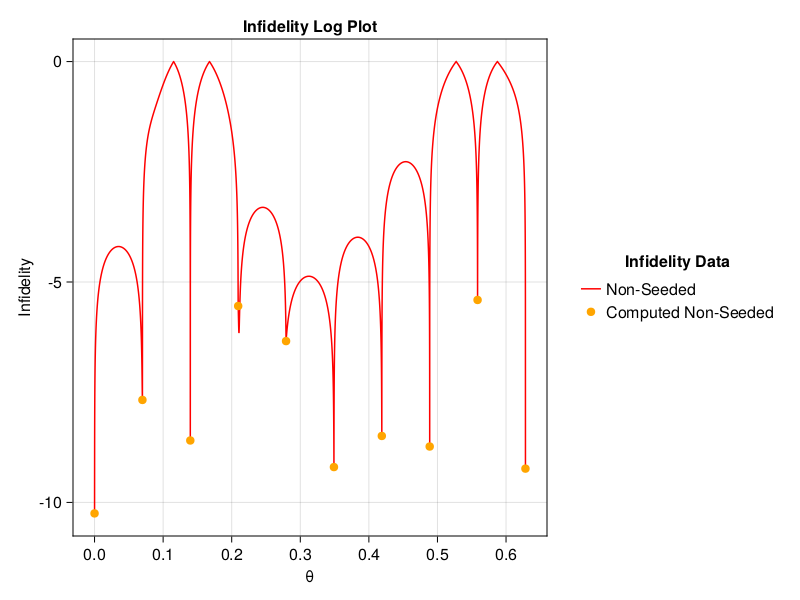

In [11]:

f = Figure()
ax = Axis(f[1, 1],
    title = "Infidelity Log Plot",
    xlabel = "θ",
    ylabel = "Infidelity"
)
lines!(ax, range(0,pi/5,10000), log10.(convert(Array{Float64,1},initial_DATA)), label  = "Non-Seeded",color = :red)
scatter!(ax, range(0,pi/5,10),log10.(convert(Array{Float64,1},initial_infidelities)), label  = "Computed Non-Seeded",color = :orange)

f[1, 2] = Legend(f, ax, "Infidelity Data", framevisible = false)
f
     